# Sentiment Analysis using BERT

BERT (Bidirectionnal Encoder Representations for Transformers) is a “new method of pre-training language representations” developed by Google and released in late 2018.

### Import Libraries and Set the intial variables

In [1]:
# forked from https://www.kaggle.com/code/prakharrathi25/sentiment-analysis-using-bert

In [2]:
!pip install transformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import logging


# Misc.
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Set verbosity
logging.basicConfig(level=logging.INFO)
transformers.logging.set_verbosity_info()

In [7]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load the data

In [8]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.shape

(50000, 2)

In [9]:
# Let's have a look at the data 
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == "positive" else 0)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


We can see that the most relevant column for us is content and replyContent and the score as well.

## Data Preprocessing

Machine Learning models don’t work with raw text. You need to convert text to numerical representation. BERT requires even more attention when it comes to this representation. 

Here are the requirements:

* Add special tokens to separate sentences and do classification
* Pass sequences of constant length (introduce padding)
* Create array of 0s (pad token) and 1s (real token) called attention mask

BERT offers a few model architectures and I will be using one of them combined with manual preprocessing. I am using the cased version which considers GREAT and great to be to different entities and BAD might be given more focus than bad.  

The tokenizer will break the sentence into words and give numerical values to each word. 

In [10]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

https://huggingface.co/bert-base-cased/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmp62ns3tqx


storing https://huggingface.co/bert-base-cased/resolve/main/vocab.txt in cache at /root/.cache/torch/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
creating metadata file for /root/.cache/torch/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
loading file https://huggingface.co/bert-base-cased/resolve/main/vocab.txt from cache at /root/.cache/torch/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791


In [11]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review.

In [13]:
# Store length of each review 
token_lens = []

# Iterate through the content slide, take the first 10,000 rows
for txt in tqdm(df.review[:10000], desc="Tokenizing reviews"):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

Tokenizing reviews: 100%|██████████| 10000/10000 [01:20<00:00, 124.39it/s]


Text(0.5, 0, 'Token count')

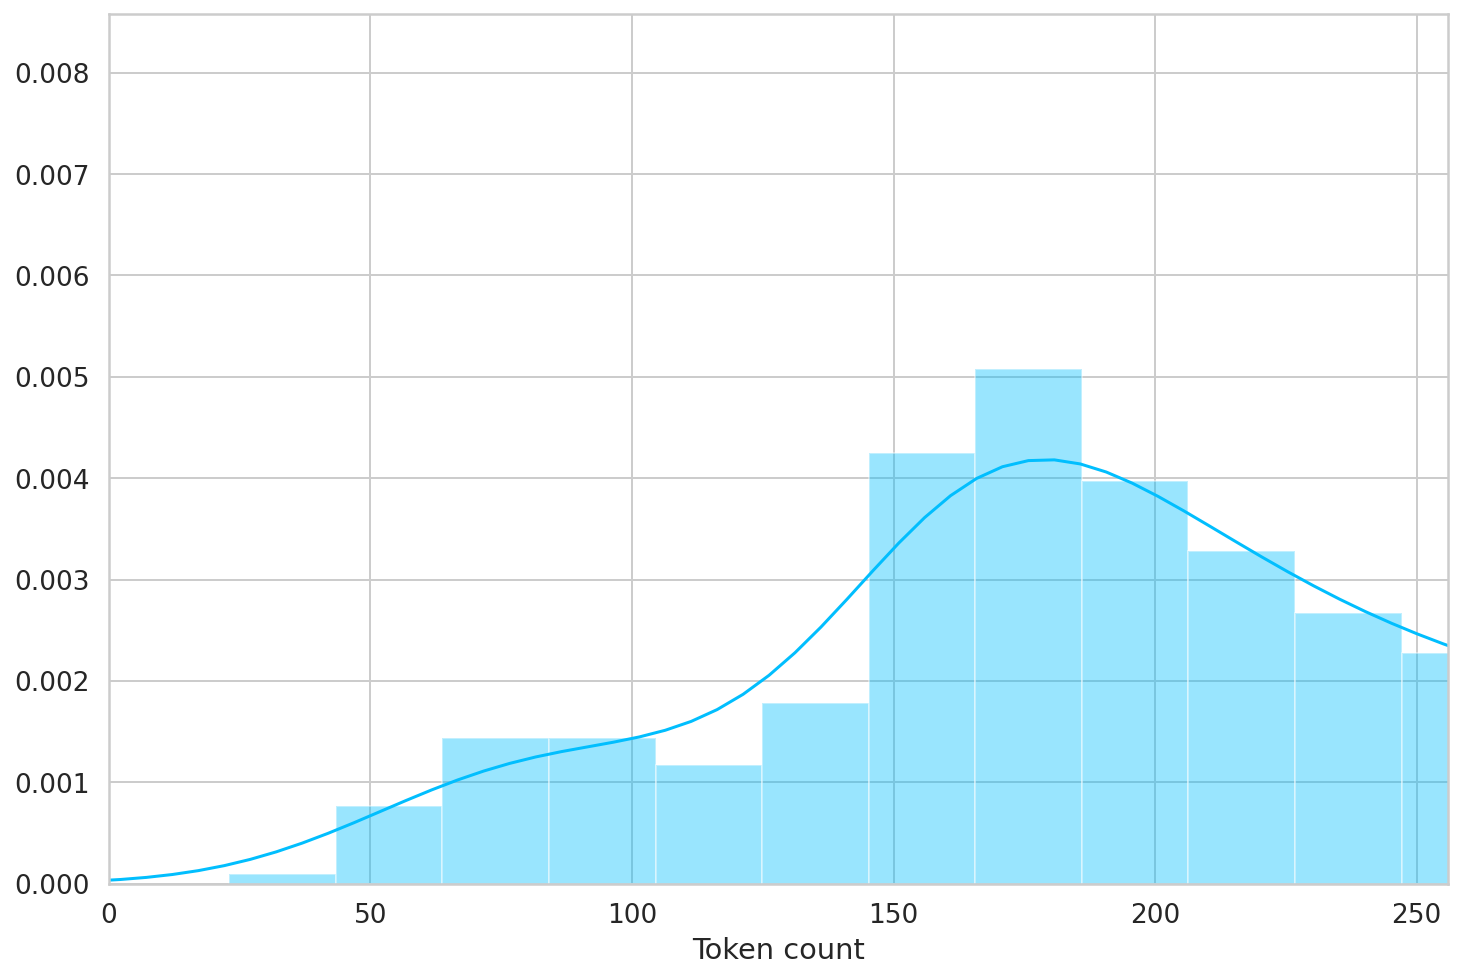

In [14]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

All of the reviews seem to contain less than 250 tokens

In [15]:
MAX_LEN = 250

### Preparing Torch Dataset

To enter data into a PyTorch, we need a more robust data generator class. We will return the review text as well to validate our predictions easily. 

In [16]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
#         encoding = self.tokenizer.encode_plus(
#             review,
#             add_special_tokens=True,
#             max_length=self.max_len,
#             return_token_type_ids=False,
#             pad_to_max_length=True,
#             return_attention_mask=True,
#             return_tensors='pt',
#         )
    # Note: we could tokenize the text the entire dataset from the very beginning like in the LSTM notebook, but the example notebook did it this way

        # https://huggingface.co/docs/transformers/v4.42.0/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.__call__.return_attention_mask
        encoding = self.tokenizer(review, max_length=self.max_len, truncation=True, return_token_type_ids=False, padding="max_length", return_attention_mask=True, return_tensors='pt')
        input_ids, attention_mask = encoding.values()
        #print(f"input shape is {input_ids.shape}")
        #print(f"attention_mask shape is {attention_mask.shape}")
        return {
            'review_text': review,
            'input_ids': input_ids.flatten(),
            'attention_mask': attention_mask.flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

Create a 80% train data and 10% test and 10% validation data

In [17]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(40000, 2) (5000, 2) (5000, 2)


Create a dataloader to release data in batches.

In [18]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.review.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
    )

In [19]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [20]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 250])
torch.Size([16, 250])
torch.Size([16])


In [21]:
print(data['input_ids'])
print(data['attention_mask'])
print(data['review_text'])

tensor([[  101,  1337,   112,  ...,   119,   133,   102],
        [  101,   146,  1225,  ...,  1136, 22821,   102],
        [  101,   138,  6893,  ...,     0,     0,     0],
        ...,
        [  101,   142,  2162,  ...,  6276,  1590,   102],
        [  101,   146,  1138,  ...,  1133,   146,   102],
        [  101,   170,  2523,  ...,     0,     0,     0]])
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])
['That\'s what I kept asking myself during the many fights, screaming matches, swearing and general mayhem that permeate the 84 minutes. The comparisons also stand up when you think of the one-dimensional characters, who have so little depth that it is virtually impossible to care what happens to them. They are just badly written cyphers for the director to hang his multicultural beliefs on, a topic that has been don

## Sentiment Classification with BERT and Hugging Face

We’ll use the basic BertModel and build our sentiment classifier on top of it. Let’s load the model

In [22]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)

https://huggingface.co/bert-base-cased/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmps43sdbp1


storing https://huggingface.co/bert-base-cased/resolve/main/config.json in cache at /root/.cache/torch/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
creating metadata file for /root/.cache/torch/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/torch/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_ep

storing https://huggingface.co/bert-base-cased/resolve/main/pytorch_model.bin in cache at /root/.cache/torch/transformers/092cc582560fc3833e556b3f833695c26343cb54b7e88cd02d40821462a74999.1f48cab6c959fc6c360d22bea39d06959e90f5b002e77e836d2da45464875cda
creating metadata file for /root/.cache/torch/transformers/092cc582560fc3833e556b3f833695c26343cb54b7e88cd02d40821462a74999.1f48cab6c959fc6c360d22bea39d06959e90f5b002e77e836d2da45464875cda
loading weights file https://huggingface.co/bert-base-cased/resolve/main/pytorch_model.bin from cache at /root/.cache/torch/transformers/092cc582560fc3833e556b3f833695c26343cb54b7e88cd02d40821462a74999.1f48cab6c959fc6c360d22bea39d06959e90f5b002e77e836d2da45464875cda


All model checkpoint weights were used when initializing BertModel.

All the weights of BertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertModel for predictions without further training.


In [23]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

We use a dropout layer for some regularization and a fully-connected layer for our output. We are returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work. Create an instance and move it to the GPU

In [24]:
# Instantiate the model and move to classifier
model = SentimentClassifier(2)
model = model.to(device)

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/torch/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.0.dev0",
  "type_vocab_size": 2,
  "vocab_size": 28996
}

loading weights file https://huggingface.co/bert-base-cased/resolve/main/pytorch_model.bin from cache at /root/.cache/torch/transformers/092cc582560fc3833e556b

#### Model Characterstics

In [25]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


### Training Phase

we’ll use the AdamW optimizer provided by Hugging Face. It corrects weight decay. We’ll also use a linear scheduler with no warmup

In [26]:
# Number of iterations 
EPOCHS = 10

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [27]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

Write a function to evaluate model performance

In [28]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

Write the training Loop and store the best training state.

In [29]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.2895830261750147 accuracy 0.8818
Val   loss 0.24556103937280255 accuracy 0.9068

Epoch 2/10
----------
Train loss 0.1674315276972484 accuracy 0.95035
Val   loss 0.31839938346778573 accuracy 0.9132

Epoch 3/10
----------
Train loss 0.11106250509237871 accuracy 0.97275
Val   loss 0.42772611738580574 accuracy 0.9142

Epoch 4/10
----------
Train loss 0.07249853450473165 accuracy 0.9845750000000001
Val   loss 0.5078489774689874 accuracy 0.9178000000000001

Epoch 5/10
----------
Train loss 0.048130037538905164 accuracy 0.990375
Val   loss 0.547403428852692 accuracy 0.9108

Epoch 6/10
----------
Train loss 0.03591334303957992 accuracy 0.993125
Val   loss 0.513597079800604 accuracy 0.9162

Epoch 7/10
----------
Train loss 0.022398079459698055 accuracy 0.996025
Val   loss 0.5781094464496904 accuracy 0.9152

Epoch 8/10
----------
Train loss 0.016303122600086498 accuracy 0.997175
Val   loss 0.621647607970705 accuracy 0.9168000000000001

Epoch 9/10
----------
Tra

The above took a lot of time but it's finally working. Now, we can plot the training and validation accuracy.

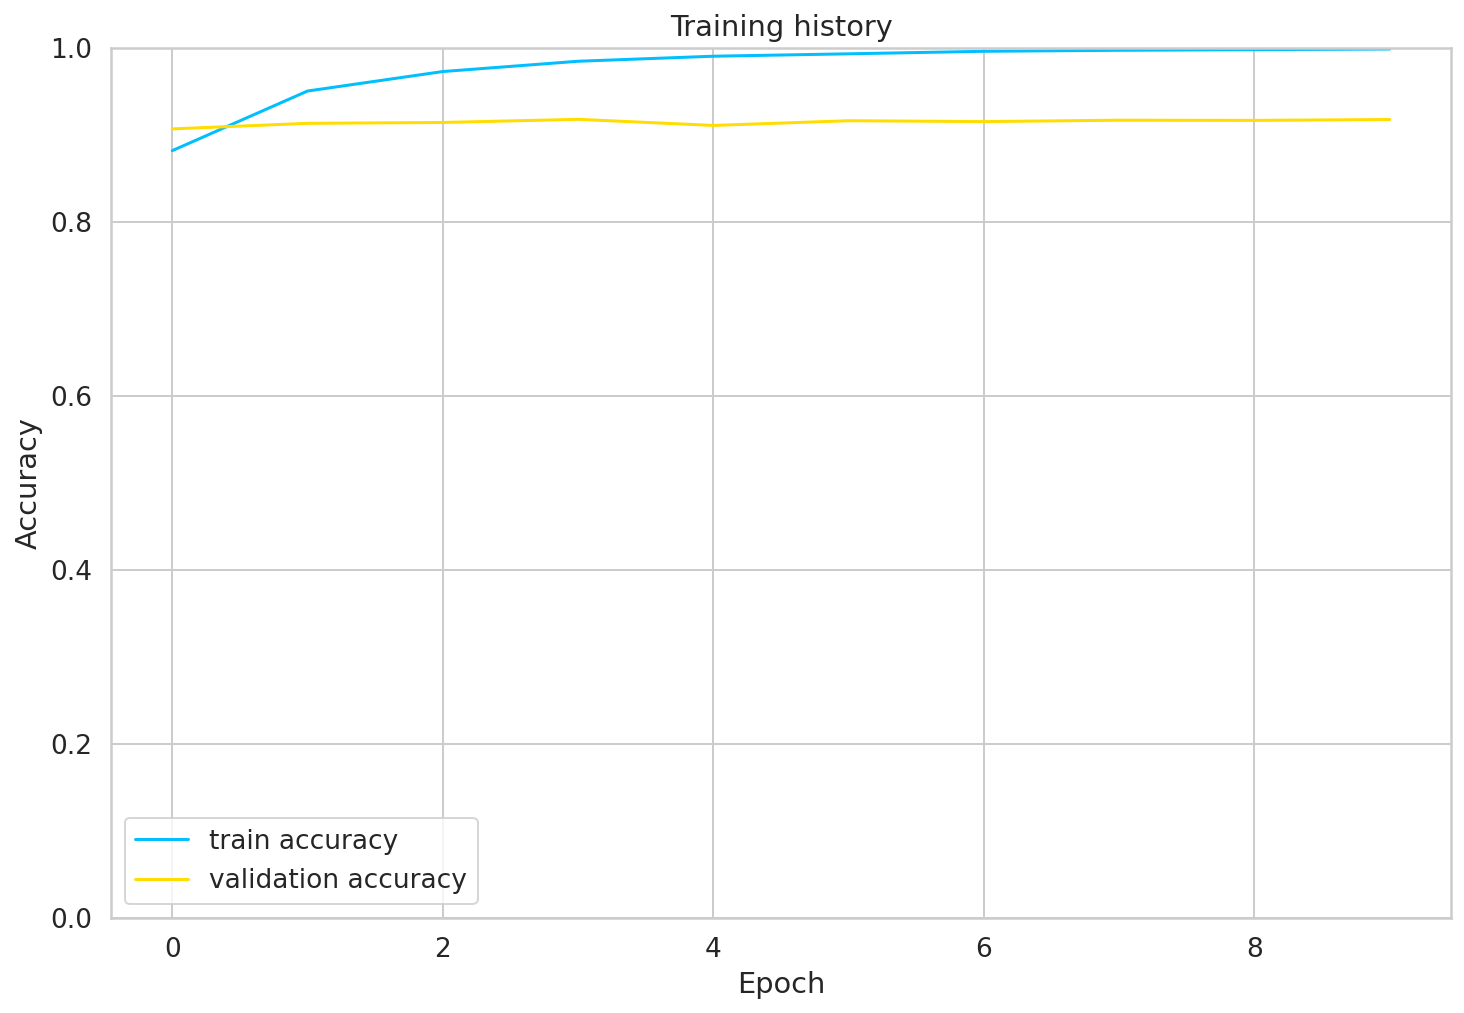

In [30]:
# Plot training and validation accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Model Evaluation

In [31]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9202

Define a helper function to get predictions from our models. This is similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities

In [32]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [33]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [34]:
print(classification_report(y_test, y_pred, target_names=class_names))

NameError: name 'class_names' is not defined

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That’s a good overview of the performance of our model.

## Predicting on raw text

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

In [ ]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')